In [30]:
%load_ext autoreload
%autoreload 2

import sys

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

import datetime
%matplotlib inline
import time

sys.path.insert(0, '/home/subtle/jon/tools/SimpleElastix/build/SimpleITK-build/Wrapping/Python/Packaging/build/lib.linux-x86_64-3.5/SimpleITK')
import SimpleITK as sitk


import subtle_preprocess as sup
import subtle_io as suio
import subtle_plot as suplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load data

In [31]:
path_zero = '/home/subtle/Data/Stanford/lowcon/Patient_0435/8_AX_BRAVO'
path_low = '/home/subtle/Data/Stanford/lowcon/Patient_0435/11_AX_BRAVO_+C_pre_load_10%'
path_full = '/home/subtle/Data/Stanford/lowcon/Patient_0435/14_AX_BRAVO_+C'


In [32]:
ims_zero, hdr_zero = suio.dicom_files(path_zero)
ims_low, hdr_low = suio.dicom_files(path_low)
ims_full, hdr_full = suio.dicom_files(path_full)

print(ims_zero.shape, ims_low.shape, ims_full.shape)

(168, 512, 512) (168, 512, 512) (168, 512, 512)


## grab some images to train

(168, 3, 512, 512)


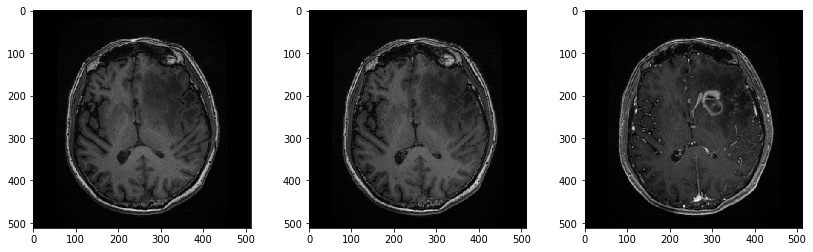

In [34]:
idx_train = np.arange(ims_zero.shape[0])
# idx_train = np.arange(20, 120)
ims = np.stack((ims_zero[idx_train,:,:], ims_low[idx_train,:,:], ims_full[idx_train,:,:]), axis=1)
print(ims.shape)

idx_plot = idx_train[len(idx_train)//2]
plt.figure(figsize=(14,4))
suplot.imshow3(ims[idx_plot,:,:,:])

In [35]:
suplot.myshow3d(ims[:,0,:,:].squeeze(), figsize=(5,5))

interactive(children=(IntSlider(value=83, description='z', max=167), Output()), _dom_classes=('widget-interact…

## mask

In [36]:
N, n, nx, ny = ims.shape
# n = ims.shape[1] # number of contrast images, including target (probably 3)
# N = ims.shape[0] # number of examples (probably hundreds)

MASK_VAL = .08
mask = sup.mask_im(ims, threshold=MASK_VAL)

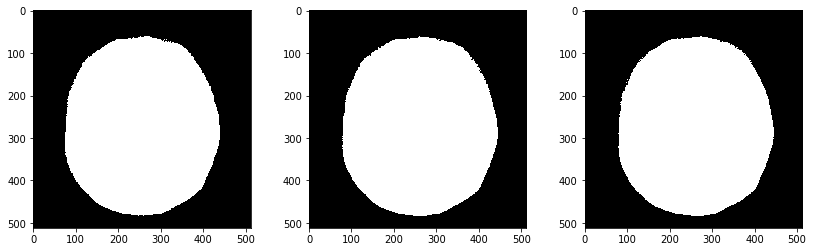

interactive(children=(IntSlider(value=83, description='z', max=167), Output()), _dom_classes=('widget-interact…

In [37]:
plt.figure(figsize=(14,4))
suplot.imshow3(mask[idx_plot,:,:,:])
suplot.myshow3d(mask[:,0,:,:].astype(np.float).squeeze(), figsize=(5,5))

In [38]:
im0 = np.squeeze(ims[:,0,:,:] * mask[:,0,:,:])
im1 = np.squeeze(ims[:,1,:,:] * mask[:,1,:,:])

sim0 = sitk.GetImageFromArray(im0)
sim1 = sitk.GetImageFromArray(im1)

## image scaling

In [39]:
im1_scaled = sup.scale_im(im0, im1, levels=1024, points=1024, mean_intensity=False)



image intensity normalization
scaling done, 4.42 s


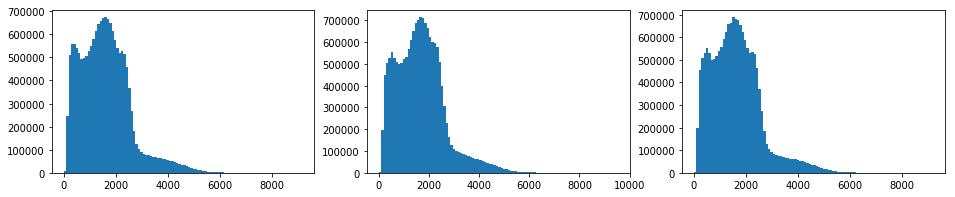

interactive(children=(IntSlider(value=83, description='z', max=167), Output()), _dom_classes=('widget-interact…

In [40]:
plt.figure(figsize=(16,3))
plt.subplot(1,3,1)
plt.hist(im0[im0>0].ravel(), 100)
plt.subplot(1,3,2)
plt.hist(im1[im1>0].ravel(), 100)
plt.subplot(1,3,3)
plt.hist(im1_scaled[im1_scaled>0].ravel(), 100);

z = np.concatenate((im0, im1, im1_scaled), axis=2)
suplot.myshow3d(z, figsize=(15,5))

## image registration

In [41]:
# spars = sitk.GetDefaultParameterMap('translation')
spars = sitk.GetDefaultParameterMap('rigid')

im1_next = im1_scaled.copy()
im1_reg, spars_reg = sup.register_im(im0, im1_next, param_map=spars, verbose=True)

print('transform parameters: {}'.format(spars_reg[0]['TransformParameters']))

image registration
registration done, 14.1 s
transform parameters: ('-1.0713e-05', '-0.00150461', '0.00953765', '3.83351', '0.762558', '0.346924')


In [42]:
z = np.concatenate((np.abs(im0-im1_next), np.abs(im0-im1_reg)), axis=2)
suplot.imshowcmp(im0, im1_next, figsize=(5,5))
suplot.imshowcmp(im0, im1_reg, figsize=(5,5))
suplot.myshow3d(z, figsize=(10,10))


interactive(children=(IntSlider(value=83, description='z', max=167), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=83, description='z', max=167), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=83, description='z', max=167), Output()), _dom_classes=('widget-interact…